Necessary Module Importation

Regression Analysis: Building Models to Predict Store Sales Using Time Series Forecasting

Introduction
Time series forecasting involves making scientific predictions by analyzing historical data with timestamps. This process entails constructing models through a detailed examination of past data, which are then utilized to make informed projections, guiding future strategic decision-making. It's important to recognize that during the forecasting process, the future outcome is entirely unknown and can only be approximated through meticulous analysis and evidence-based assumptions.

Project Objective
The primary goal of this project is to predict product unit sales across various stores, aiming to enhance inventory management, refine marketing strategies, and optimize pricing decisions for Favorita Corporation. To achieve this objective, we employ a combination of time series analysis and regression-based machine learning algorithms within the CRISP-DM framework.

This analysis seeks to identify the most effective prediction model from a diverse set of machine learning algorithms tested. The chosen model will be recommended to Favorita Corporation, providing valuable insights to facilitate informed decisions regarding retail sales, promotional activities, and customer satisfaction. By leveraging time series regression analysis, we aim to achieve a robust and reliable forecast of store sales, thereby supporting strategic planning and operational efficiency.

HYPOTHESIS TESTING 

Null Hypothesis (H0): The predictive model does not significantly improve the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model (e.g., a naive forecast using historical averages or a simple moving average).

Alternative Hypothesis (H1): The predictive model significantly improves the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model.

ANALYTICAL QUESTIONS
1.Is the train dataset complete (has all the required dates)?
2.Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3.Compare the sales for each month across the years and determine which month of which year had the highest sales.
4.Did the earthquake impact sales?
5.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6.Are sales affected by promotions, oil prices and holidays?
7.What analysis can we get from the date and its extractable features?
8.Which product family and stores did the promotions affect.
9.What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10.Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


In [64]:
#Import libraries needed for data manipulation, cleaning and visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
# Models

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor


In [65]:
#import all the necessary libraries need to laod data from microsoft SQL server

import pyodbc    
from dotenv import dotenv_values
import warnings 

warnings.filterwarnings('ignore')

In [66]:
#Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('D:\mayaya project\Business-Forecasting-Model\.env')

#Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#Create a connection string
connection_string = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=200"

connection = pyodbc.connect(connection_string)
print("Connection successful")

Connection successful


In [67]:
query="SELECT * FROM dbo.oil"
query2="SELECT * FROM dbo.holidays_events"
query3= "SELECT * FROM dbo.stores"
oil_data= pd.read_sql(query, connection)
holidays_data= pd.read_sql(query2, connection)
stores_data= pd.read_sql(query3, connection)

#### Load dataset from Onedrive

In [68]:
sample_submission = pd.read_csv('../Data/sample_submission.csv')
test = pd.read_csv('../Data/test.csv')

#### Load datasets from Github

In [69]:
train= pd.read_csv(r"D:\mayaya project\Business-Forecasting-Model\Data\train.csv")
transactions= pd.read_csv(r"D:\mayaya project\Business-Forecasting-Model\Data\transaction.csv")

#### Data Preview and Investigation

In [70]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [71]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


stores_data.head()

In [72]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [73]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [74]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### **Data wrangling**
Data wrangling, also known as data munging, involves transforming and mapping raw data into a more useful format for analysis. This process typically includes cleaning, structuring, and enriching the raw data to ensure its quality and usability for building predictive models. 

In [75]:
holidays_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [76]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [77]:
holidays_data.shape

(350, 6)

In [78]:
holidays_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [79]:
holidays_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Holiday Dataset Structure: The holiday dataset comprises 350 rows and 6 columns, providing a comprehensive overview of holiday-related data points.

2.Date Column Format: The date column is currently in an object (string) format, which will need to be converted to a datetime format for proper time series analysis.

3.Data Completeness: The dataset is complete with no missing values,  no duplicated values,  ensuring the integrity and reliability of the data for subsequent analysis.

4.Date Column Format: The date column is currently in an object (string) format and needs to be converted to a datetime format to facilitate proper time series analysis.

In [80]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [81]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [82]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [83]:
oil_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Oil Dataset Structure: The oil dataset consists of 1218 rows and 2 columns, providing extensive information on oil prices over time.

2.Missing Values: The dataset contains 43 null values, which will need to be addressed through data cleaning techniques to ensure the accuracy of the analysis.

3.Data Uniqueness: There are no duplicate entries in the dataset, maintaining its integrity.

4.Date Column Format: The date column is currently in an object (string) format and needs to be converted to a datetime format to facilitate proper time series analysis.

In [84]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [85]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [86]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [87]:
transactions.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Data Completeness: The dataset is fully populated with no null values, ensuring high data quality and reliability for analysis.

2.Date Column Format: The date column is currently stored as an object (string) format. For accurate time series analysis, it is necessary to convert this column to a datetime format.

3.Data structure: it has 83488 rows and Three columns

In [88]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [89]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [90]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [91]:
stores_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Correct Data Types: All attributes in the dataset are correctly formatted, ensuring that the data is ready for analysis without the need for additional type conversions.

2.No Duplicate Entries: The dataset contains no duplicate records, which maintains its integrity and ensures the uniqueness of each data point.**
1.Correct Data Types: All attributes in the dataset are correctly formatted, ensuring that the data is ready for analysis without the need for additional type conversions.

3.No Duplicate Entries: The dataset contains no duplicate records, which maintains its integrity and ensures the uniqueness of each data point.

In [92]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [94]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Data Visualization

Univariate Analysis

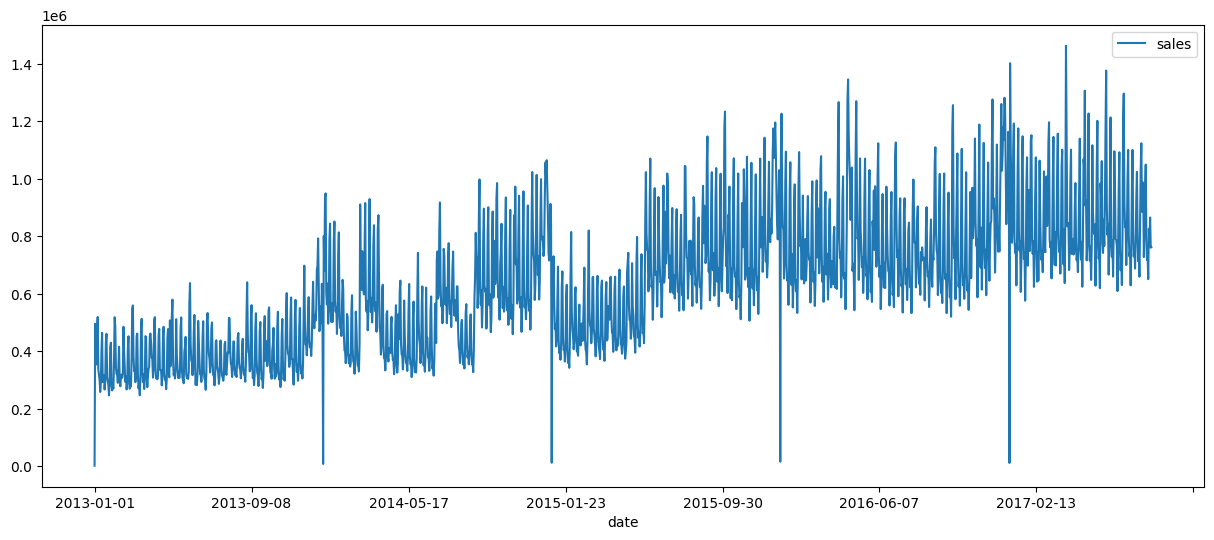

In [95]:
sales_trend = train.groupby('date').sales.sum().reset_index()    
sales_trend = sales_trend.set_index('date')

sales_trend.plot(figsize=(15, 6))
plt.show()

OBSERVATIONS
The training data exhibits an upward trend overall, indicating increasing sales over time. However, it is noteworthy that there is a significant decline in sales at the beginning of each year. This recurring pattern suggests potential seasonal factors or market dynamics that negatively impact sales during this period.

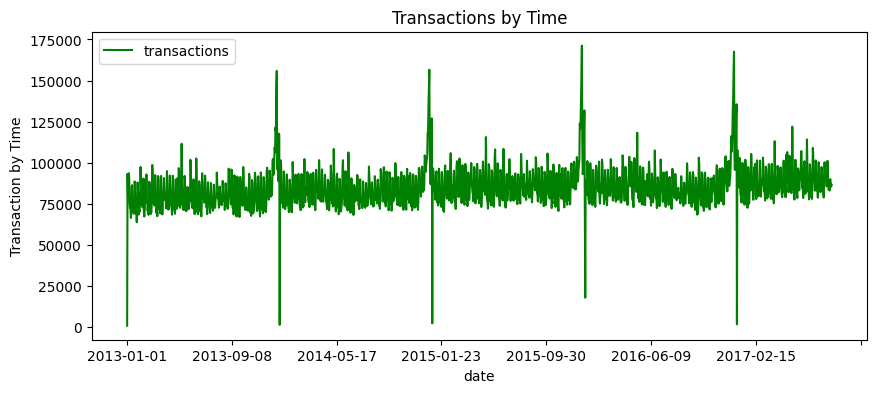

In [96]:
transaction_trend= transactions.groupby("date").transactions.sum().reset_index()
transaction_trend= transaction_trend.set_index("date")

transaction_trend.plot(figsize= (10,4), color= ("green"))
plt.title("Transactions by Time")
plt.ylabel("Transaction by Time")
plt.show()

OBSERVATIONS
A detailed analysis reveals a consistent upward trend in yearly transactions, with 2016 emerging as the year with the highest sales records. Despite this overall growth, the month-to-month transaction levels remain relatively stable throughout the years. Notably, there are sharp increases in transactions during year-end periods, highlighting a distinct seasonal pattern in sales activity.








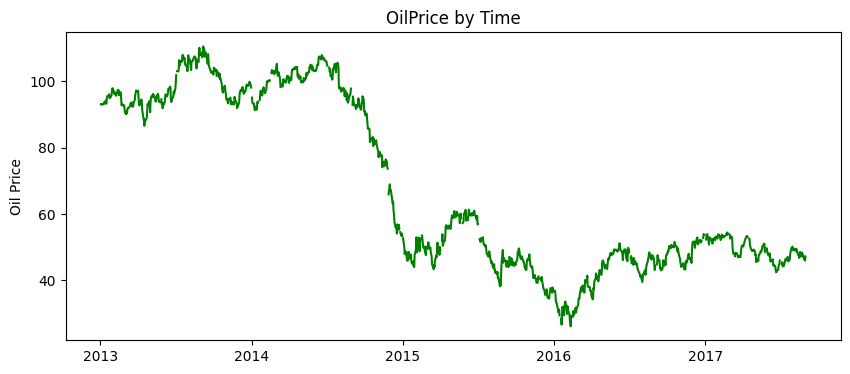

In [97]:
oil_data["date"]= pd.to_datetime(oil_data["date"])
oil_price_overtime= oil_data.groupby("date")["dcoilwtico"].mean().reset_index()
oil_price_by_time = oil_price_overtime.set_index('date')

plt.figure(figsize=(10,4))
plt.plot(oil_price_by_time.index,  oil_price_by_time["dcoilwtico"], color= "green")
plt.title("OilPrice by Time")
plt.ylabel("Oil Price")
plt.show()


OBSERVATIONS
The trend reveals a decline in oil prices starting from 2015. This downward trajectory is further interrupted by noticeable disruptions, which are linked to the presence of missing or NaN values in the dataset. These gaps underscore the need for careful data cleaning to ensure an accurate and continuous analysis of the oil price trends.

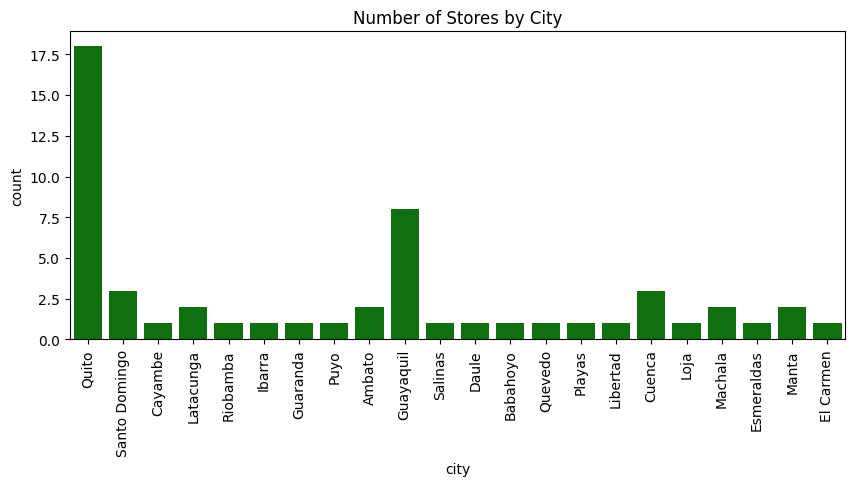

In [98]:
store_by_city= stores_data.set_index('store_nbr', inplace=True)
plt.figure(figsize=(10, 4))
sns.countplot(data=stores_data, x='city', color= 'green')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

OBSERVATIONS
The visual representation reveals that Quito and Guayaquil have the highest number of stores compared to other cities, which typically maintain an average of one store each. This concentration of stores in Quito and Guayaquil highlights their significance as major retail hubs within the dataset.








#### Holidays investigation

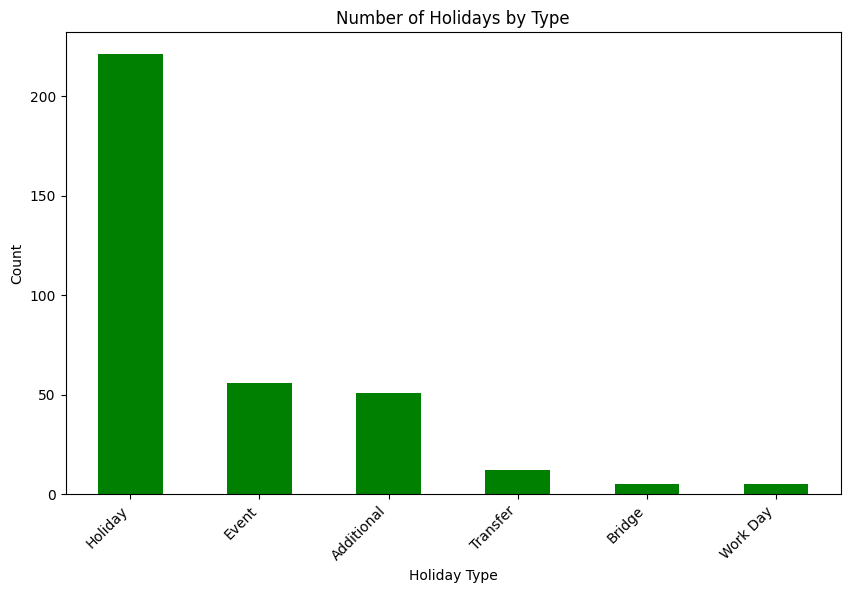

In [99]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='green')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Data Preparation
Converting the date columns from their current format to a proper datetime format is essential. This transformation will enable accurate time series analysis and facilitate various date-based operations, such as sorting, filtering, and time-based aggregation, ensuring the integrity and precision of our analysis.